In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')

In [3]:
# Set the HF_HOME environment variable
os.environ['HF_HOME'] = '/path/to/cache/directory'  # Update this path to your cache directory

In [4]:
# Load the dataset
file_path = '3026NMfixed_RC.csv'
df = pd.read_csv(file_path)

In [7]:
# Encode the 'ut' column
le_ut = LabelEncoder()
df['rc'] = le_ut.fit_transform(df['rc'])

In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['utterance'], df['rc'], test_size=0.2, random_state=42)

In [9]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [10]:
# Tokenize the utterances and pad sequences to max length 128
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding='max_length', max_length=128)
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding='max_length', max_length=128)

In [11]:
# Convert encodings to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train)).shuffle(len(X_train)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_test)).batch(32)

In [12]:
# Load the BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [13]:
# Define the custom neural network with BERT embeddings
input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='attention_mask')

In [14]:
# Use a Lambda layer to correctly process inputs and specify the output shape
def process_bert(inputs):
    input_ids, attention_mask = inputs
    bert_outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
    return bert_outputs.last_hidden_state

bert_outputs = tf.keras.layers.Lambda(process_bert, output_shape=(128, 768))([input_ids, attention_mask])
cls_token = bert_outputs[:, 0, :]

# Modify the model architecture
x = tf.keras.layers.Dense(256, activation='relu')(cls_token)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(len(le_ut.classes_), activation='softmax')(x)

model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output)

In [15]:
# Compile the model with a lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
# Increase the number of epochs
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset)

Epoch 1/10


C:\Users\soon1\AppData\Local\Temp\__autograph_generated_filelv19sw74.py:63: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  ag__.converted_call(ag__.ld(warnings).warn, (ag__.converted_call('Input dict contained keys {} which did not match any model input. They will be ignored by the model.'.format, ([ag__.ld(n) for n in ag__.converted_call(ag__.ld(tensors).keys, (), None, fscope) if ag__.ld(n) not in ag__.ld(ref_input_names)],), None, fscope),), dict(stacklevel=2), fscope)


15/15 [==============================] - 81s 3s/step - loss: 2.3954 - accuracy: 0.1416 - val_loss: 2.1770 - val_accuracy: 0.0000e+00
Epoch 2/10
15/15 [==============================] - 34s 2s/step - loss: 2.4152 - accuracy: 0.1084 - val_loss: 2.1020 - val_accuracy: 0.0088
Epoch 3/10
15/15 [==============================] - 35s 2s/step - loss: 2.3358 - accuracy: 0.1350 - val_loss: 2.0358 - val_accuracy: 0.0177
Epoch 4/10
15/15 [==============================] - 38s 3s/step - loss: 2.2296 - accuracy: 0.1527 - val_loss: 1.9790 - val_accuracy: 0.0354
Epoch 5/10
15/15 [==============================] - 35s 2s/step - loss: 2.1865 - accuracy: 0.1637 - val_loss: 1.9272 - val_accuracy: 0.0708
Epoch 6/10
15/15 [==============================] - 34s 2s/step - loss: 2.0909 - accuracy: 0.1858 - val_loss: 1.8810 - val_accuracy: 0.1770
Epoch 7/10
15/15 [==============================] - 36s 2s/step - loss: 2.1110 - accuracy: 0.1925 - val_loss: 1.8391 - val_accuracy: 0.2566
Epoch 8/10
15/15 [=========

In [17]:
# Evaluate the model
eval_results = model.evaluate(test_dataset)

4/4 [==============================] - 6s 1s/step - loss: 1.7374 - accuracy: 0.3363


In [19]:
# Predict on the test set
predictions = model.predict(test_dataset)
pred_labels = np.argmax(predictions, axis=1)

4/4 [==============================] - 6s 1s/step


In [20]:
# Calculate accuracy
accuracy = accuracy_score(y_test, pred_labels)
print(f"Test set accuracy: {accuracy:.4f}")

Test set accuracy: 0.3363


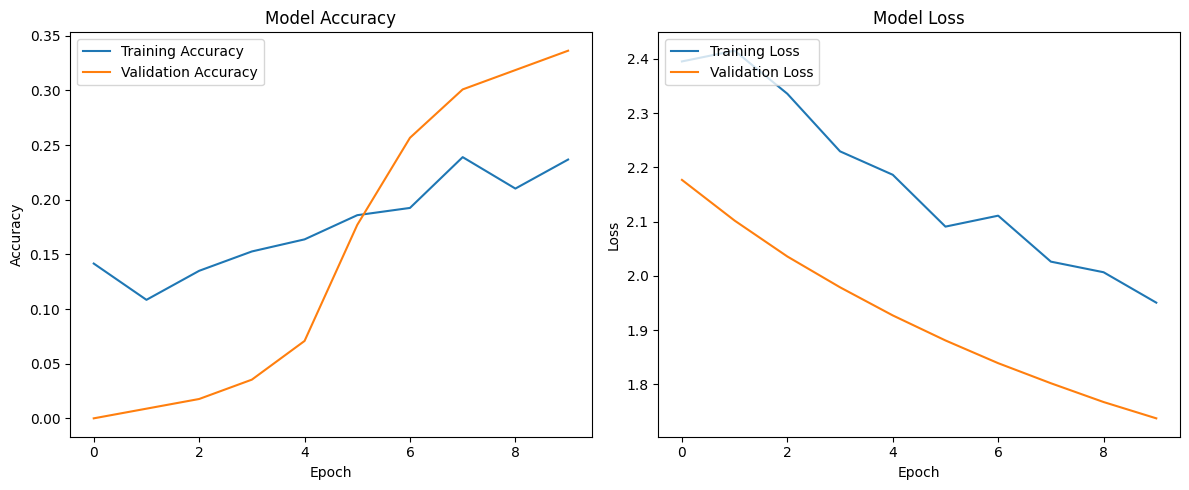

In [21]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()